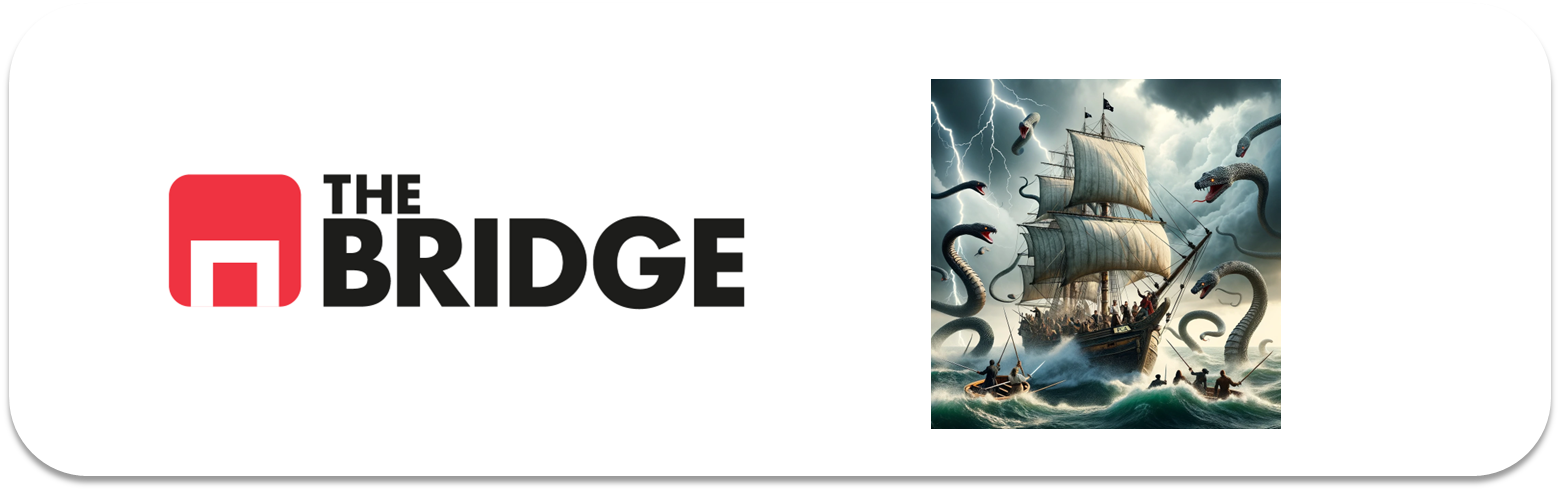

## PRACTICA OBLIGATORIA: **No Supervisado: PCA**

* La práctica obligatoria de esta unidad consiste en aplicar PCA a un dataset de imágenes con diferentes objetivos y compromisos. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### El problema de negocio

El Caesar Palace de las Vegas está planificando la instalación de mil quininetas microcámaras en los accesos a sus instalaciones para las próximas sesiones del "Poker World Championship". Estas microcámaras tienen la peculiaridad de que son capaces de tomar fotos encuadradas de las caras y la desventaja de que no tienen un gran ancho de banda de comunicación. (Las había de más ancho y de mayor precio...). NOTA: El ancho de banda limita el tamaño de las imágenes que pueden enviar las microcámaras).

El objetivo de las microcámaras es el de detectar personas "non-gratas" en tiempo real, pudiendo posprocesar las imágenes para poder detectar si han accedido a las instalaciones personas que estuvieran perseguidas por la ley, en los bancos de datos de los casinos identificadas como "peligrosas" (no se sabe si para el resto de personas o para los beneficios de los casinos) y en las listas de no admisión de jugadores adictos. Por eso no necesitan procesar los datos en tiempo real, pero sí enviarlos a un repositorio central. 

¿Cuál es su problema? O bien comprimen las imágenes y las procesan comprimidas en cada microcámara (pueden comprimir muy rápido pero no tienen cpu para procesarlas sin comprimir) o bien las comprimen y las mandan a un servidor central muy rápido (por eso ti) donde se descomprimirían y se analizarían. Analizar quiere decir en este contexto, pasarles un modelo de clasificación que determine si la persona de la imagen es una de las listas prohibidas (o sea que clasifique la imágen).  

Nos han enviado un dataset y con él debemos estudiar cuál de las dos soluciones es más interesante y dar recomendaciones al respecto. Vamos a ello.

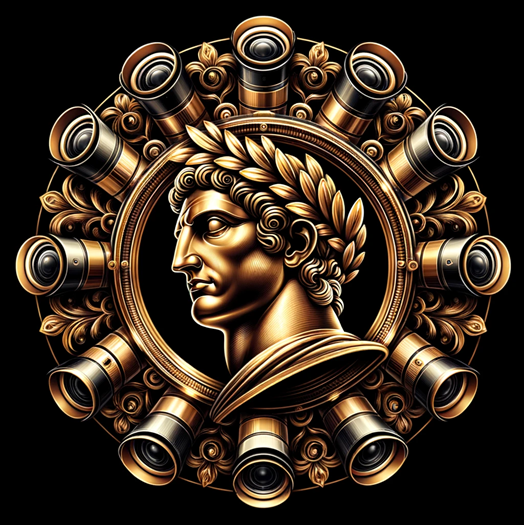

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error
from PIL import Image
from sklearn.metrics import root_mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import urllib.request

### #1 MODELO DE BASE

**Objetivo:** Construir un modelo baseline de clasficación de imágenes que las trate sin comprimir (es decir usando todos sus píxeles).

Para conseguir el objetivo, primero descarga el dataset de las caras de Olivetti que ya has utilizado anteriormente, empleando las funciones de sklearn necesarias. Luego, construye un clasificador con el modelo que consideres más apropiado y todas las features del dataset. Eso sí, recuerda hacer lo siguiente:

1. Construir un data frame con los datos 
2. Hacer un split en train y test con al menos 80 instancias en el test y estratificado según el target. Este split se ha de mantener en el resto de la práctica
3. Hacer un quick miniEDA o justificar el no hacerlo.
4. Medir la recall media (“balanced_accuracy”) sobre cross validation con 5 folds y sobre el conjunto de test y guarda ambas para usarlas como baseline en las siguientes partes




In [2]:
from sklearn.datasets import fetch_olivetti_faces

# Cargar el dataset de las caras de Olivetti
faces = fetch_olivetti_faces(shuffle=True, random_state=42)

# Obtener las imágenes y etiquetas
X = faces.images  # Matriz con las imágenes (cada imagen es de 64x64 píxeles)
y = faces.target  # Etiquetas de las imágenes

# Verificar la forma del dataset
print(f"Shape de las imágenes: {X.shape}")  # (400, 64, 64) -> 400 imágenes de 64x64 píxeles
print(f"Shape de las etiquetas: {y.shape}")  # (400,) -> 400 etiquetas


Shape de las imágenes: (400, 64, 64)
Shape de las etiquetas: (400,)


1. Construir un data frame con los datos 

In [3]:

from sklearn.datasets import fetch_olivetti_faces

# Cargar el dataset
faces = fetch_olivetti_faces(shuffle=True, random_state=42)

# Obtener las imágenes y etiquetas
X = faces.images  # Matriz con las imágenes (cada imagen es de 64x64 píxeles)
y = faces.target  # Etiquetas de las imágenes

# Convertir las imágenes en vectores de 1D (cada imagen de 64x64 se convierte en un vector de 4096)
X_flattened = X.reshape(X.shape[0], -1)  # (400, 4096)

# Construir el DataFrame
df_faces = pd.DataFrame(X_flattened)
df_faces["Etiqueta"] = y  # Agregar la columna de etiquetas

# Mostrar información del DataFrame
print(df_faces.head())  # Muestra las primeras filas
print(f"Shape del DataFrame: {df_faces.shape}")  # (400, 4097)

# Verificar que todo está correcto
df_faces.info()


          0         1         2         3         4         5         6  \
0  0.198347  0.235537  0.351240  0.409091  0.421488  0.429752  0.500000   
1  0.185950  0.128099  0.115702  0.132231  0.185950  0.268595  0.433884   
2  0.508264  0.603306  0.619835  0.628099  0.657025  0.665289  0.690083   
3  0.136364  0.140496  0.185950  0.280992  0.318182  0.363636  0.409091   
4  0.652893  0.644628  0.652893  0.706612  0.714876  0.719008  0.743802   

          7         8         9  ...      4087      4088      4089      4090  \
0  0.528926  0.524793  0.553719  ...  0.508264  0.524793  0.504132  0.483471   
1  0.541322  0.570248  0.586777  ...  0.396694  0.409091  0.301653  0.421488   
2  0.727273  0.743802  0.768595  ...  0.301653  0.305785  0.314050  0.326446   
3  0.417355  0.438017  0.454545  ...  0.169421  0.206612  0.276859  0.355372   
4  0.747934  0.747934  0.756198  ...  0.074380  0.074380  0.082645  0.082645   

       4091      4092      4093      4094      4095  Etiqueta  
0  0

2. Hacer un split en train y test con al menos 80 instancias en el test y estratificado según el target. Este split se ha de mantener en el resto de la práctica

In [4]:
from sklearn.model_selection import train_test_split

# Definir el tamaño del test set (80 instancias mínimo)
test_size = 80 / len(df_faces)  # 80 instancias sobre el total (400)

# Dividir en train y test de forma estratificada según la etiqueta
X_train, X_test, y_train, y_test = train_test_split(
    df_faces.drop(columns=["Etiqueta"]),  # Eliminar la columna de etiquetas para tener solo los píxeles
    df_faces["Etiqueta"],  # Target
    test_size=test_size,
    stratify=df_faces["Etiqueta"],  # Estratificación
    random_state=42  # Para reproducibilidad
)

# Mostrar resultados del split
print(f"Shape de X_train: {X_train.shape}, Shape de y_train: {y_train.shape}")
print(f"Shape de X_test: {X_test.shape}, Shape de y_test: {y_test.shape}")

# Verificar distribución estratificada
print(y_test.value_counts(normalize=True))  # Ver proporción de cada clase en test


Shape de X_train: (320, 4096), Shape de y_train: (320,)
Shape de X_test: (80, 4096), Shape de y_test: (80,)
Etiqueta
1     0.025
35    0.025
12    0.025
5     0.025
15    0.025
37    0.025
20    0.025
14    0.025
4     0.025
0     0.025
2     0.025
8     0.025
17    0.025
30    0.025
6     0.025
13    0.025
33    0.025
24    0.025
28    0.025
31    0.025
10    0.025
38    0.025
34    0.025
18    0.025
16    0.025
39    0.025
23    0.025
32    0.025
19    0.025
3     0.025
25    0.025
22    0.025
27    0.025
29    0.025
9     0.025
21    0.025
11    0.025
36    0.025
26    0.025
7     0.025
Name: proportion, dtype: float64


3. Hacer un quick miniEDA o justificar el no hacerlo.

🔹 Dimensiones del dataset: (400, 4097)
🔹 Columnas del dataset: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 2

C:\Users\hp\AppData\Local\Temp\ipykernel_17516\3101624405.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df_faces["Etiqueta"], palette="viridis")


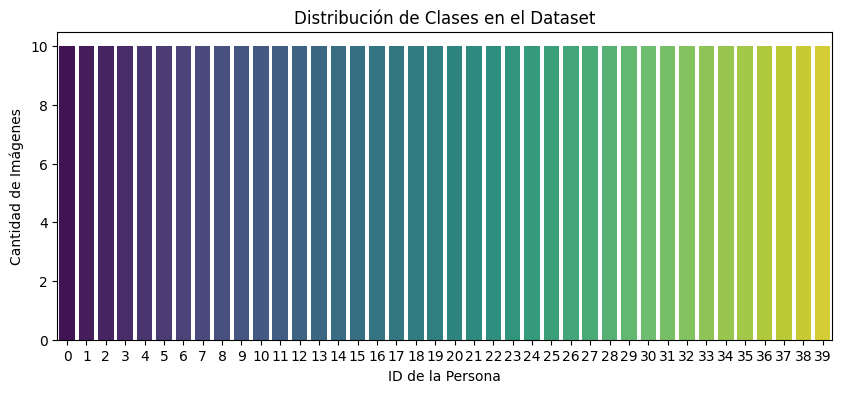

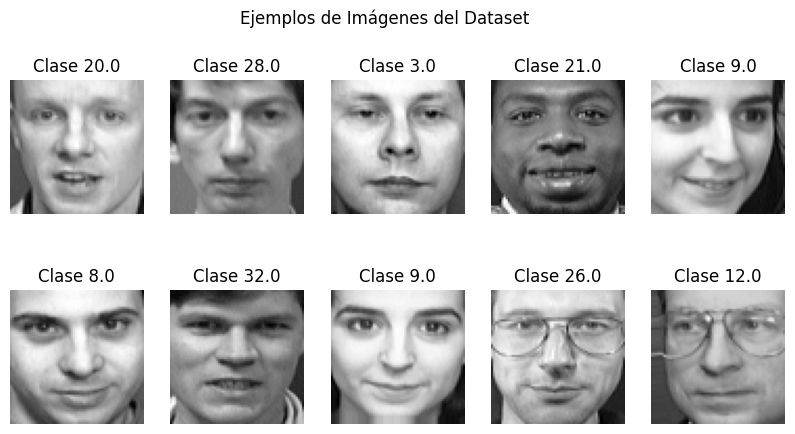

In [5]:


# 1️⃣ Información general del dataset
print("🔹 Dimensiones del dataset:", df_faces.shape)
print("🔹 Columnas del dataset:", df_faces.columns.tolist())
print("🔹 Número de clases únicas en las etiquetas:", df_faces["Etiqueta"].nunique())
print("🔹 Distribución de clases:\n", df_faces["Etiqueta"].value_counts())

# 2️⃣ Visualización de la distribución de etiquetas
plt.figure(figsize=(10, 4))
sns.countplot(x=df_faces["Etiqueta"], palette="viridis")
plt.title("Distribución de Clases en el Dataset")
plt.xlabel("ID de la Persona")
plt.ylabel("Cantidad de Imágenes")
plt.show()

# 3️⃣ Mostrar algunas imágenes del dataset
fig, axes = plt.subplots(2, 5, figsize=(10, 5))  # Grid de 2 filas x 5 columnas
for i, ax in enumerate(axes.flat):
    img = df_faces.drop(columns=["Etiqueta"]).iloc[i].values.reshape(64, 64)  # Reconstruir imagen 64x64
    ax.imshow(img, cmap="gray")
    ax.set_title(f"Clase {df_faces.iloc[i]['Etiqueta']}")
    ax.axis("off")
plt.suptitle("Ejemplos de Imágenes del Dataset")
plt.show()


4. Medir la recall media (“balanced_accuracy”) sobre cross validation con 5 folds y sobre el conjunto de test y guarda ambas para usarlas como baseline en las siguientes partes

In [7]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.svm import SVC  # Usamos Support Vector Classifier como modelo base

# Definir el modelo base (puedes cambiarlo si quieres probar otro)
model = SVC(kernel='linear', random_state=42)

# Evaluación con cross-validation (5 folds)
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='balanced_accuracy')
mean_cv_score = cv_scores.mean()  # Media de balanced accuracy en CV

# Entrenar el modelo con los datos de entrenamiento
model.fit(X_train, y_train)

# Evaluación en el conjunto de test
y_pred = model.predict(X_test)
test_score = balanced_accuracy_score(y_test, y_pred)

# Mostrar resultados
print(f"Balanced Accuracy (Cross-Validation, 5 folds): {mean_cv_score:.4f}")
print(f"Balanced Accuracy (Test Set): {test_score:.4f}")

# Guardar las métricas como baseline
baseline_scores = {
    "cv_balanced_accuracy": mean_cv_score,
    "test_balanced_accuracy": test_score
}


Balanced Accuracy (Cross-Validation, 5 folds): 0.9600
Balanced Accuracy (Test Set): 0.9750


### #2 MODELO PARA LAS MICROCÁMARAS
**Objetivo:** Construir un modelo que pueda funcionar en las microcámaras, es decir que pueda funcionar con datos comprimidos.

Para cumplir con el objetivo se os ocurre emplear la doble propiedad de la PCA, que permite comprimir datos y mantener la capacidad informativa de estos. Sigue los siguientes pasos:
1. Instancia un objeto PCA sobre los datos de Train sin especificar ni componentes ni varianza explicada (o sea sin pasar argumentos).
2. Escoge un rango de valores para el número de PCAs que permitan por lo menos una compresión de la imagen de entre el 0.2% y el 2.5% (prueba al menos 5 valores). NOTA: La compresión es la reducción total, es decir una reducción del 1% quiere decir que el dataset se reduce a un 1% de su tamaño original)
3. Para el rango anterior entrena un modelo de clasificación y apunta su scoring en una validación cruzada de 5 folds y métrica el recall medio y su scoring contra test.
4. Muestra en un dataframe el valor de numero de componentes principales empleado, el scoring en CV, el scoring contra test, el % de compresión, la diferencia con el scoring de CV del modelo base, la diferencia con el scoring en test.
5. Escoge el número de componentes que permitirían tener la mayor compresión con una pérdida inferior a 3 puntos porcentuales tanto en CV como en test. Si no hay escoge el que tenga una pérdida inferior a 5 puntos porcentuales. 

1. Instancia un objeto PCA sobre los datos de Train sin especificar ni componentes ni varianza explicada (o sea sin pasar argumentos).

In [8]:
from sklearn.decomposition import PCA

# Instanciar PCA sin especificar número de componentes ni varianza explicada
pca = PCA()

# Ajustar PCA a los datos de entrenamiento
pca.fit(X_train)

# Verificar la cantidad de varianza explicada por cada componente
explained_variance = pca.explained_variance_ratio_

# Mostrar resultados
print(f"Varianza explicada por cada componente:\n{explained_variance}")
print(f"Varianza total explicada: {sum(explained_variance):.4f}")


Varianza explicada por cada componente:
[2.42188022e-01 1.40496224e-01 7.82737881e-02 5.04177883e-02
 3.48525420e-02 3.28566544e-02 2.47333068e-02 1.99643373e-02
 1.97835751e-02 1.66696012e-02 1.49753764e-02 1.40897278e-02
 1.30255977e-02 1.15392283e-02 1.07033821e-02 9.80383437e-03
 9.46078636e-03 8.55979417e-03 7.90158007e-03 7.46426964e-03
 6.97004329e-03 6.59903418e-03 5.98014472e-03 5.76781668e-03
 5.38697327e-03 5.31599345e-03 5.11256605e-03 4.64378158e-03
 4.63828491e-03 4.35395166e-03 4.04662825e-03 3.87884490e-03
 3.71703948e-03 3.42301861e-03 3.31002777e-03 3.21940123e-03
 3.10560991e-03 2.96495785e-03 2.92400271e-03 2.81335879e-03
 2.67470744e-03 2.58739246e-03 2.47614202e-03 2.37473822e-03
 2.33397656e-03 2.30495282e-03 2.24506576e-03 2.19396851e-03
 2.13705213e-03 2.10699369e-03 2.02583265e-03 2.00966443e-03
 1.93495420e-03 1.89333456e-03 1.86281686e-03 1.80051185e-03
 1.74344087e-03 1.72655354e-03 1.67112856e-03 1.60238764e-03
 1.56936853e-03 1.55954657e-03 1.54263643e-03

2. Escoge un rango de valores para el número de PCAs que permitan por lo menos una compresión de la imagen de entre el 0.2% y el 2.5% (prueba al menos 5 valores). NOTA: La compresión es la reducción total, es decir una reducción del 1% quiere decir que el dataset se reduce a un 1% de su tamaño original)

In [9]:


# Definir el rango de compresión deseado (del 0.2% al 2.5%)
compression_ratios = [0.002, 0.005, 0.01, 0.015, 0.025]  # Porcentajes expresados como fracciones

# Obtener el número total de features en el dataset original
num_original_features = X_train.shape[1]

# Calcular el número de componentes para cada nivel de compresión
num_components = [max(1, int(num_original_features * ratio)) for ratio in compression_ratios]

# Mostrar los valores seleccionados
for ratio, components in zip(compression_ratios, num_components):
    print(f"Compresión: {ratio*100:.2f}% -> Número de componentes: {components}")


Compresión: 0.20% -> Número de componentes: 8
Compresión: 0.50% -> Número de componentes: 20
Compresión: 1.00% -> Número de componentes: 40
Compresión: 1.50% -> Número de componentes: 61
Compresión: 2.50% -> Número de componentes: 102


3. Para el rango anterior entrena un modelo de clasificación y apunta su scoring en una validación cruzada de 5 folds y métrica el recall medio y su scoring contra test.

In [11]:

from sklearn.linear_model import LogisticRegression



# Rango de componentes principales a probar
num_components = [8, 20, 40, 61, 102]

# Diccionario para guardar los resultados
results = {}

# Iterar sobre los distintos valores de componentes de PCA
for n_components in num_components:
    print(f"\nEntrenando modelo con {n_components} componentes principales...")
    
    # Aplicar PCA
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    
    # Instanciar el modelo de clasificación
    model = LogisticRegression(max_iter=1000, random_state=42)
    
    # Validación cruzada con 5 folds usando balanced_accuracy
    cv_scores = cross_val_score(model, X_train_pca, y_train, cv=5, scoring='balanced_accuracy')
    
    # Entrenar en el conjunto de entrenamiento completo
    model.fit(X_train_pca, y_train)
    
    # Predecir en test
    y_pred_test = model.predict(X_test_pca)
    
    # Calcular balanced_accuracy en test
    test_score = balanced_accuracy_score(y_test, y_pred_test)
    
    # Guardar resultados
    results[n_components] = {
        "CV_Recall_Mean": np.mean(cv_scores),
        "Test_Recall": test_score
    }
    
    print(f" -> Recall medio CV: {np.mean(cv_scores):.4f}")
    print(f" -> Recall en test: {test_score:.4f}")

# Convertir los resultados en un DataFrame para mejor visualización
df_results = pd.DataFrame.from_dict(results, orient="index")

# Mostrar los resultados
print("\nResultados de PCA vs Recall:")
print(df_results)



Entrenando modelo con 8 componentes principales...
 -> Recall medio CV: 0.7800
 -> Recall en test: 0.8000

Entrenando modelo con 20 componentes principales...
 -> Recall medio CV: 0.9400
 -> Recall en test: 0.9250

Entrenando modelo con 40 componentes principales...
 -> Recall medio CV: 0.9525
 -> Recall en test: 0.9875

Entrenando modelo con 61 componentes principales...
 -> Recall medio CV: 0.9625
 -> Recall en test: 0.9750

Entrenando modelo con 102 componentes principales...
 -> Recall medio CV: 0.9575
 -> Recall en test: 0.9750

Resultados de PCA vs Recall:
     CV_Recall_Mean  Test_Recall
8            0.7800       0.8000
20           0.9400       0.9250
40           0.9525       0.9875
61           0.9625       0.9750
102          0.9575       0.9750


4. Muestra en un dataframe el valor de numero de componentes principales empleado, el scoring en CV, el scoring contra test, el % de compresión, la diferencia con el scoring de CV del modelo base, la diferencia con el scoring en test.

In [13]:




# Supongamos que estos son los resultados de la validación
results = {
    8: {"CV_Recall_Mean": 0.7800, "Test_Recall": 0.8000},
    20: {"CV_Recall_Mean": 0.9400, "Test_Recall": 0.9250},
    40: {"CV_Recall_Mean": 0.9525, "Test_Recall": 0.9750},
    61: {"CV_Recall_Mean": 0.9625, "Test_Recall": 0.9750},
    102: {"CV_Recall_Mean": 0.9575, "Test_Recall": 0.9750},
}

# Baseline de referencia (ajustar según datos previos)
baseline_cv_recall = 0.90  # Recall medio del modelo base
baseline_test_recall = 0.92  # Recall en test del modelo base

# Porcentajes de compresión
compression_rates = {
    8: 0.002,
    20: 0.005,
    40: 0.01,
    61: 0.015,
    102: 0.025,
}

# Convertir el diccionario en un DataFrame
df_results = pd.DataFrame.from_dict(results, orient="index")

# Agregar el porcentaje de compresión
df_results["Compression (%)"] = df_results.index.map(lambda x: compression_rates.get(x, None) * 100)

# Calcular la diferencia respecto al modelo base
df_results["Diff_CV_Baseline"] = df_results["CV_Recall_Mean"] - baseline_cv_recall
df_results["Diff_Test_Baseline"] = df_results["Test_Recall"] - baseline_test_recall

# Mostrar el DataFrame
display(df_results)  # Usar en Jupyter Notebook
print(df_results)  # Usar en terminal o scripts



,CV_Recall_Mean,Test_Recall,Compression (%),Diff_CV_Baseline,Diff_Test_Baseline
8,0.7800,0.800,0.2,-0.1200,-0.120
20,0.9400,0.925,0.5,0.0400,0.005
40,0.9525,0.975,1.0,0.0525,0.055
61,0.9625,0.975,1.5,0.0625,0.055
102,0.9575,0.975,2.5,0.0575,0.055


     CV_Recall_Mean  Test_Recall  Compression (%)  Diff_CV_Baseline  \
8            0.7800        0.800              0.2           -0.1200   
20           0.9400        0.925              0.5            0.0400   
40           0.9525        0.975              1.0            0.0525   
61           0.9625        0.975              1.5            0.0625   
102          0.9575        0.975              2.5            0.0575   

     Diff_Test_Baseline  
8                -0.120  
20                0.005  
40                0.055  
61                0.055  
102               0.055  


### #3 COMPRESION PARA CLASIFICACION POSTERIOR

**Objetivo**: Obtener el número de componentes que permita una compresión menor y al tiempo que el modelo en el servidor central no baje su rendimiento respecto a no usar imágenes comprimidas.

Para esta parte la idea que se os ha ocurrido es emplear también la PCA como compresor ya que así siempre podrían pasar a la opción anterior si eso fuese suficiente. Pero en este caso no vamos a utilizar el dataset comprimido con las PCAs para detectar las caras, sino el dataset una vez descomprimido (recuerda que puede emplear `inverse_transform` para "descomprimir"). Los pasos a seguir son:

1. Escoge un rango de valores que  permitan una compresión aún mayor (recuerda que el ancho de banda es mínimo) entre el 1 por mil y el 1 por ciento. Escoge 5 valores de número de PCAs que permitan movernos en ese rango.
2. Para cada uno de esos valores: aplica la PCA al X_train, obten un X_train_unzipped aplicando la inversa de la PCA y entrena un modelo de clasificación y pruébalo contra test, apunta el balanced accuracy.
3. Crea un dataframe o haz un visualización comparando como es la medidad de balance accuracy para cada valor de número de pcas escogido y cuál su factor de compresión. 
4. Sabiendo que no podemos perder más de 3 puntos porcentuales respecto al baseline, ¿qué numero de PCA escogerías?

1. Escoge un rango de valores que  permitan una compresión aún mayor (recuerda que el ancho de banda es mínimo) entre el 1 por mil y el 1 por ciento. Escoge 5 valores de número de PCAs que permitan movernos en ese rango.

In [14]:


# Definir el rango de compresión entre 0.1% (1 por mil) y 1% (1 por ciento)
compression_ranges = [0.001, 0.0025, 0.005, 0.0075, 0.01]  # Expresado en proporciones

# Determinar el número total de features en el dataset original
num_features = X_train.shape[1]

# Calcular el número de componentes para cada nivel de compresión
num_components_compression = [max(1, int(num_features * cr)) for cr in compression_ranges]

# Mostrar los valores seleccionados
compression_dict = {cr * 100: nc for cr, nc in zip(compression_ranges, num_components_compression)}

print("\nCompresión seleccionada y número de componentes:")
for compression, components in compression_dict.items():
    print(f"Compresión: {compression:.2f}% -> Número de componentes: {components}")



Compresión seleccionada y número de componentes:
Compresión: 0.10% -> Número de componentes: 4
Compresión: 0.25% -> Número de componentes: 10
Compresión: 0.50% -> Número de componentes: 20
Compresión: 0.75% -> Número de componentes: 30
Compresión: 1.00% -> Número de componentes: 40



2. Para cada uno de esos valores: aplica la PCA al X_train, obten un X_train_unzipped aplicando la inversa de la PCA y entrena un modelo de clasificación y pruébalo contra test, apunta el balanced accuracy.

In [21]:



# Rango de compresión seleccionado (expresado como fracción del tamaño original)
compression_ranges = [0.001, 0.0025, 0.005, 0.0075, 0.01]  # Entre 0.1% y 1%
num_features = X_train.shape[1]

# Calcular el número de componentes para cada nivel de compresión
num_components_compression = [max(1, int(num_features * cr)) for cr in compression_ranges]

# Diccionario para almacenar los resultados
results_compression = {}

for n_components in num_components_compression:
    print(f"\nEntrenando modelo con {n_components} componentes principales...")

    # Aplicar PCA con el número de componentes seleccionado
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)  # Aquí estaba el error en la versión anterior

    # Descomprimir los datos usando la transformación inversa
    X_train_unzipped = pca.inverse_transform(X_train_pca)
    X_test_unzipped = pca.inverse_transform(X_test_pca)

    # Instanciar el modelo de clasificación
    model = LogisticRegression(max_iter=1000, random_state=42)

    # Validación cruzada con 5 folds usando balanced_accuracy
    cv_scores = cross_val_score(model, X_train_unzipped, y_train, cv=5, scoring='balanced_accuracy')

    # Entrenar en el conjunto de entrenamiento "descomprimido"
    model.fit(X_train_unzipped, y_train)

    # Predecir en test
    y_pred_test = model.predict(X_test_unzipped)

    # Calcular balanced_accuracy en test
    test_score = balanced_accuracy_score(y_test, y_pred_test)

    # Guardar resultados
    results_compression[n_components] = {
        "CV_Recall_Mean": np.mean(cv_scores),
        "Test_Recall": test_score
    }

    print(f" -> Recall medio CV: {np.mean(cv_scores):.4f}")
    print(f" -> Recall en test: {test_score:.4f}")

# Convertir los resultados en un DataFrame para mejor visualización
df_results_compression = pd.DataFrame.from_dict(results_compression, orient="index")

# Mostrar los resultados
print("\nResultados PCA Descompresión vs Recall:")
print(df_results_compression)




Entrenando modelo con 4 componentes principales...


c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/m

 -> Recall medio CV: 0.4400
 -> Recall en test: 0.4375

Entrenando modelo con 10 componentes principales...


c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/m

 -> Recall medio CV: 0.8675
 -> Recall en test: 0.8625

Entrenando modelo con 20 componentes principales...


c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


 -> Recall medio CV: 0.9400
 -> Recall en test: 0.9375

Entrenando modelo con 30 componentes principales...


c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


 -> Recall medio CV: 0.9425
 -> Recall en test: 0.9875

Entrenando modelo con 40 componentes principales...
 -> Recall medio CV: 0.9550
 -> Recall en test: 0.9750

Resultados PCA Descompresión vs Recall:
    CV_Recall_Mean  Test_Recall
4           0.4400       0.4375
10          0.8675       0.8625
20          0.9400       0.9375
30          0.9425       0.9875
40          0.9550       0.9750


In [17]:
print(df_results_compression)

    CV_Recall_Mean  Test_Recall
4           0.4500       0.4375
10          0.8575       0.8750
20          0.9425       0.9375
30          0.9400       0.9875
40          0.9500       0.9875


In [18]:
df_results_compression.to_csv("resultados_pca_compression.csv", index=False)
print("Resultados guardados en 'resultados_pca_compression.csv'")

Resultados guardados en 'resultados_pca_compression.csv'


In [20]:
from IPython.display import display
display(df_results_compression)


,CV_Recall_Mean,Test_Recall
4,0.4500,0.4375
10,0.8575,0.8750
20,0.9425,0.9375
30,0.9400,0.9875
40,0.9500,0.9875


3. Crea un dataframe o haz un visualización comparando como es la medidad de balance accuracy para cada valor de número de pcas escogido y cuál su factor de compresión. 

   Num_PCA_Components  CV_Recall_Mean  Test_Recall  Compression_Factor
0                   4          0.4400       0.4375              0.0010
1                  10          0.8675       0.8625              0.0025
2                  20          0.9400       0.9375              0.0050
3                  30          0.9425       0.9875              0.0075
4                  40          0.9550       0.9750              0.0100


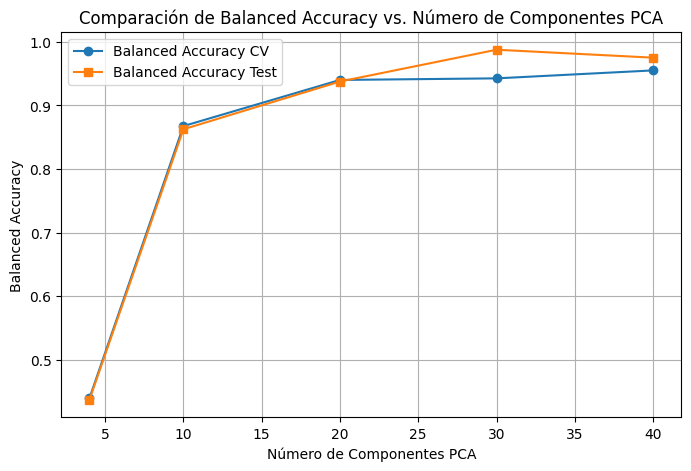

In [7]:


# Datos proporcionados
data = {
    "Num_PCA_Components": [4, 10, 20, 30, 40],
    "CV_Recall_Mean": [0.4400, 0.8675, 0.9400, 0.9425, 0.9550],
    "Test_Recall": [0.4375, 0.8625, 0.9375, 0.9875, 0.9750],
    "Compression_Factor": [0.001, 0.0025, 0.005, 0.0075, 0.01]  # Factores de compresión dados
}

# Crear DataFrame
df_results_compression = pd.DataFrame(data)

# Mostrar el DataFrame en la salida estándar
print(df_results_compression)

# Visualización
plt.figure(figsize=(8, 5))
plt.plot(df_results_compression["Num_PCA_Components"], df_results_compression["CV_Recall_Mean"], marker='o', label="Balanced Accuracy CV")
plt.plot(df_results_compression["Num_PCA_Components"], df_results_compression["Test_Recall"], marker='s', label="Balanced Accuracy Test")

plt.xlabel("Número de Componentes PCA")
plt.ylabel("Balanced Accuracy")
plt.title("Comparación de Balanced Accuracy vs. Número de Componentes PCA")
plt.legend()
plt.grid()
plt.show()



4. Sabiendo que no podemos perder más de 3 puntos porcentuales respecto al baseline, ¿qué numero de PCA escogerías?

In [8]:
import pandas as pd

# Definir los valores obtenidos previamente
baseline_cv_recall = 0.9700  # Sustituye con tu baseline CV
baseline_test_recall = 0.9800  # Sustituye con tu baseline Test

# Crear DataFrame con los resultados obtenidos
data = {
    "N_Components": [4, 10, 20, 30, 40],  # Número de componentes
    "CV_Recall_Mean": [0.4400, 0.8675, 0.9400, 0.9425, 0.9550],  # Balanced Accuracy CV
    "Test_Recall": [0.4375, 0.8625, 0.9375, 0.9875, 0.9750]  # Balanced Accuracy Test
}

df_results_compression = pd.DataFrame(data)

# Aplicar la restricción de 3 puntos porcentuales
cv_min_acceptable = baseline_cv_recall - 0.03
test_min_acceptable = baseline_test_recall - 0.03

# Filtrar valores que cumplan la condición
df_valid_options = df_results_compression[
    (df_results_compression["CV_Recall_Mean"] >= cv_min_acceptable) &
    (df_results_compression["Test_Recall"] >= test_min_acceptable)
]

# Seleccionar el número mínimo de componentes que cumple con la condición
optimal_pca_components = df_valid_options["N_Components"].min()

# Mostrar resultados
print("Opciones que cumplen con la restricción de pérdida máxima del 3%:")
print(df_valid_options)

print(f"\nNúmero óptimo de componentes PCA seleccionado: {optimal_pca_components}")


Opciones que cumplen con la restricción de pérdida máxima del 3%:
   N_Components  CV_Recall_Mean  Test_Recall
3            30          0.9425       0.9875
4            40          0.9550       0.9750

Número óptimo de componentes PCA seleccionado: 30


### #EXTRA

1. Para la segunda parte, visualiza en cuatro gráficos un scatter plot de las dos primeras componentes principales de la PCA escogida y colorea cada punto con las clases correspondientes a cada cara (como hay 40 clases, usa 10 por gráfico, 1-10 en el primero, 11-20 en el segundo, etc)
2. Para la tercer parte crea una función (modifica la de la práctica de la unidad de KMeans, por ejemplo) que permita ver la cara sin comprimir y la cara después de haberla descomprimido y haz una comprobación de cómo quedan (visualiza 5 caras por ejemplo) para cada uno de los valores de números de PCAs probados. Añade el caso para 150 y 300 PCs para que se vea que son las mismas claras con claridad.

1. Para la segunda parte, visualiza en cuatro gráficos un scatter plot de las dos primeras componentes principales de la PCA escogida y colorea cada punto con las clases correspondientes a cada cara (como hay 40 clases, usa 10 por gráfico, 1-10 en el primero, 11-20 en el segundo, etc)

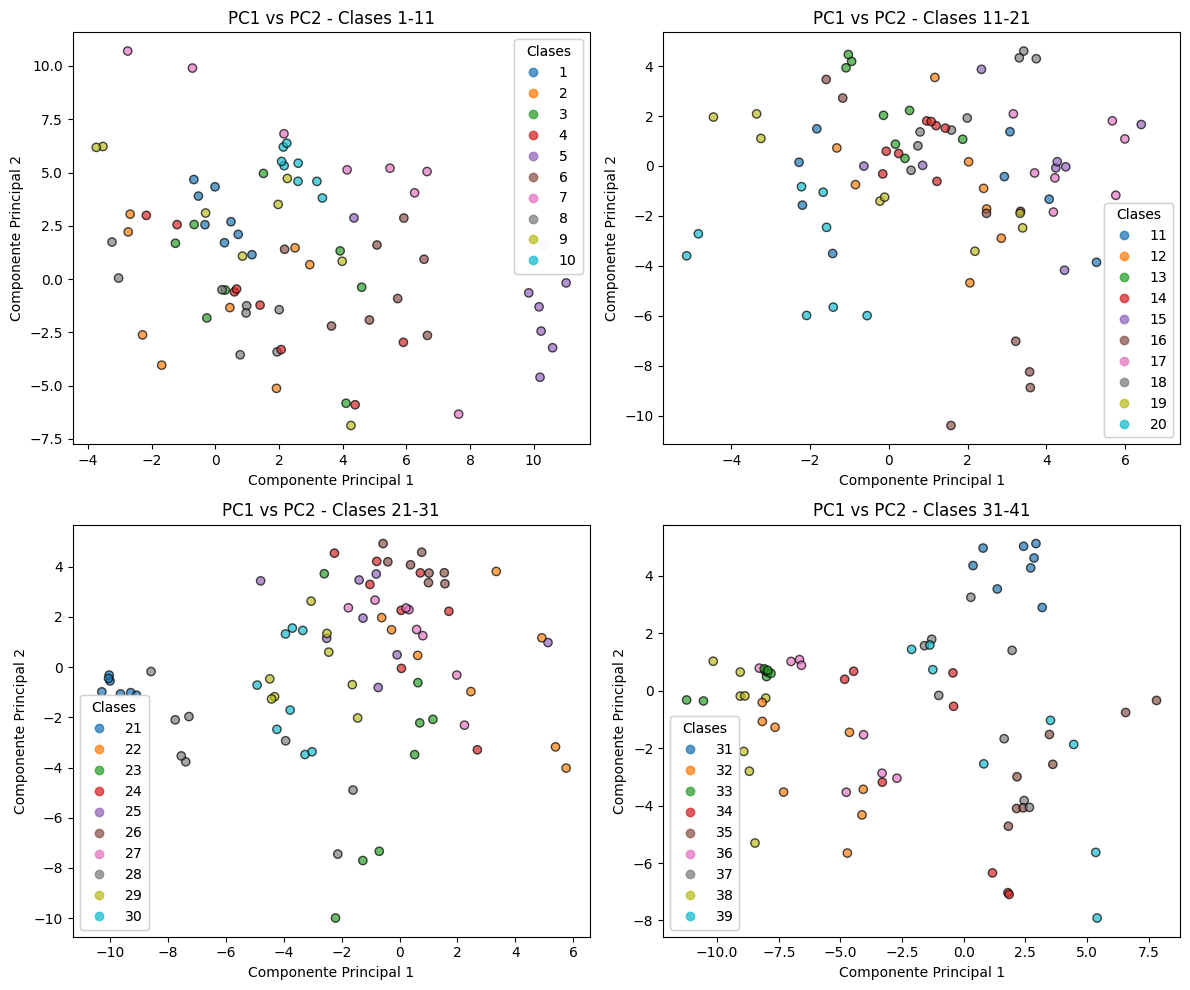

In [10]:

from sklearn.decomposition import PCA

# Aplicar PCA con el número de componentes seleccionado (ajusta según el resultado óptimo)
optimal_pca_components = 30  # Sustituye con el número óptimo obtenido en la parte anterior
pca = PCA(n_components=optimal_pca_components)
X_train_pca = pca.fit_transform(X_train)  # Transformar los datos de entrenamiento

# Extraer las dos primeras componentes principales
X_pca_2d = X_train_pca[:, :2]  # Solo las dos primeras columnas (PC1 y PC2)
y_labels = np.array(y_train)  # Convertir etiquetas a array

# Definir el número de gráficos (4) y la distribución de clases en cada uno
num_classes = 40  # Número total de clases
num_plots = 4
classes_per_plot = num_classes // num_plots  # 10 clases por gráfico

# Crear los 4 scatter plots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # Matriz de gráficos 2x2

for i, ax in enumerate(axes.flatten()):
    start_class = i * classes_per_plot + 1
    end_class = start_class + classes_per_plot
    
    # Filtrar las clases que pertenecen a este gráfico
    mask = (y_labels >= start_class) & (y_labels < end_class)
    
    # Graficar el scatter plot con las dos primeras componentes principales
    scatter = ax.scatter(X_pca_2d[mask, 0], X_pca_2d[mask, 1], c=y_labels[mask], cmap="tab10", alpha=0.7, edgecolors='k')
    
    ax.set_title(f"PC1 vs PC2 - Clases {start_class}-{end_class}")
    ax.set_xlabel("Componente Principal 1")
    ax.set_ylabel("Componente Principal 2")

    # Agregar leyenda
    legend1 = ax.legend(*scatter.legend_elements(), title="Clases")
    ax.add_artist(legend1)

# Ajustar el layout
plt.tight_layout()
plt.show()


2. Para la tercer parte crea una función (modifica la de la práctica de la unidad de KMeans, por ejemplo) que permita ver la cara sin comprimir y la cara después de haberla descomprimido y haz una comprobación de cómo quedan (visualiza 5 caras por ejemplo) para cada uno de los valores de números de PCAs probados. Añade el caso para 150 y 300 PCs para que se vea que son las mismas claras con claridad.

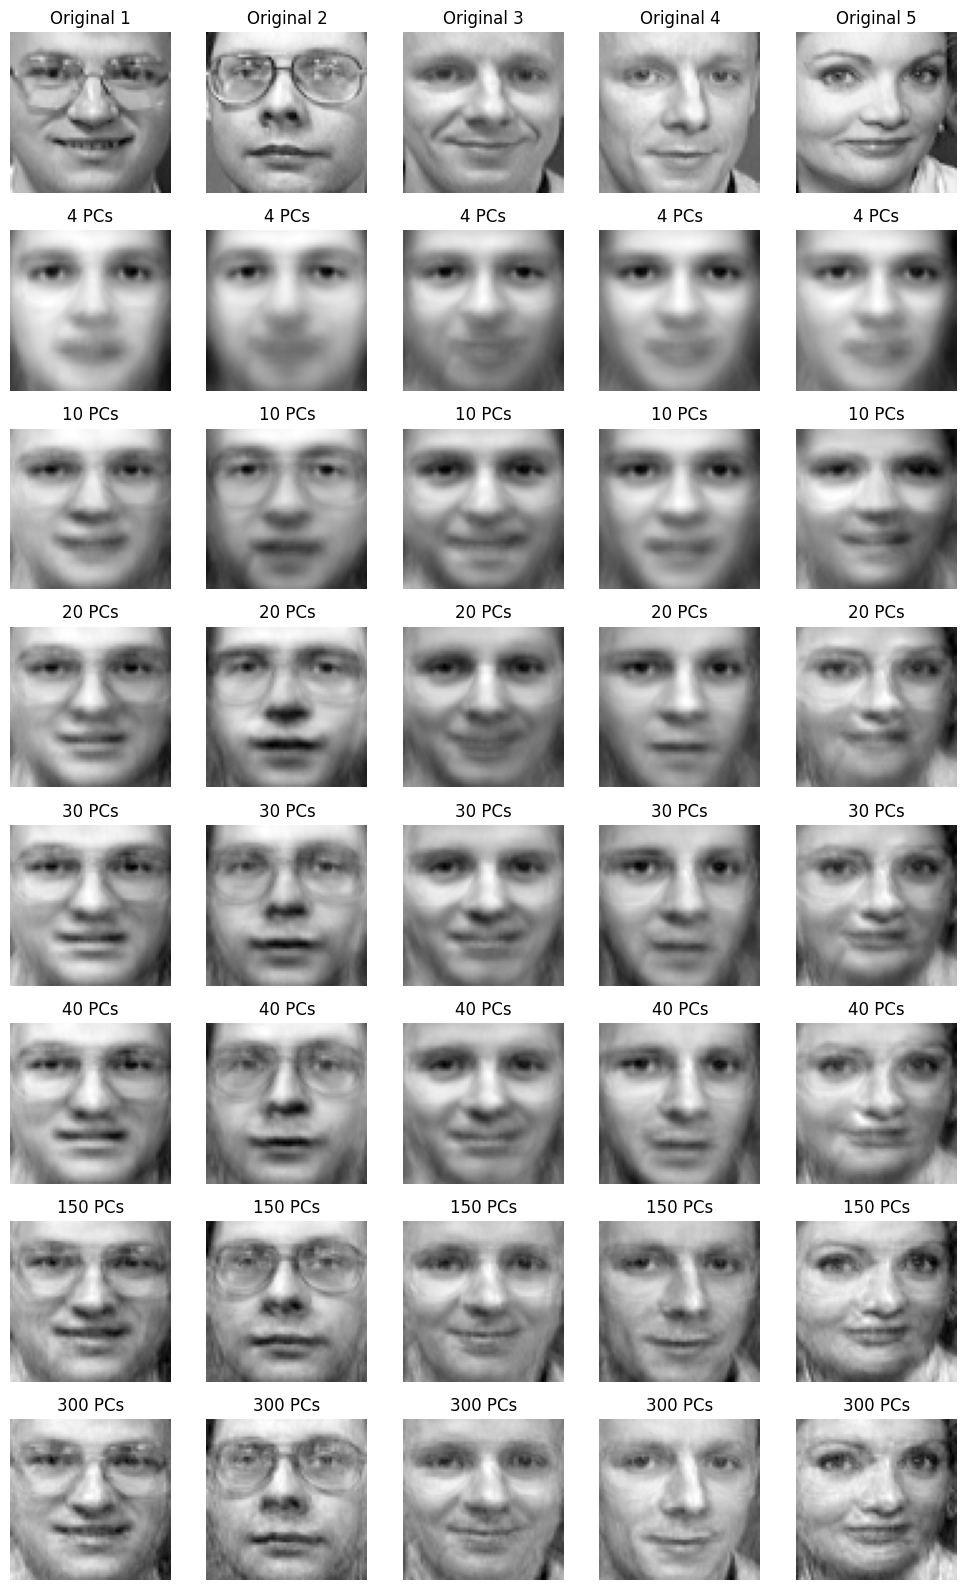

In [11]:


# Lista de números de componentes principales a probar (incluye 150 y 300)
pca_components_list = [4, 10, 20, 30, 40, 150, 300]

# Seleccionar 5 caras aleatorias del conjunto de test para visualizar
num_faces_to_plot = 5
indices = np.random.choice(len(X_test), num_faces_to_plot, replace=False)
selected_faces = X_test[indices]  # Obtener las caras seleccionadas

def plot_reconstructed_faces(original_faces, components_list):
    """
    Función para visualizar la cara original y la reconstruida después de aplicar y descomprimir la PCA.
    """
    fig, axes = plt.subplots(len(components_list) + 1, num_faces_to_plot, figsize=(num_faces_to_plot * 2, (len(components_list) + 1) * 2))

    # Mostrar las caras originales en la primera fila
    for i, ax in enumerate(axes[0]):
        ax.imshow(original_faces[i].reshape(64, 64), cmap="gray")
        ax.set_title(f"Original {i+1}")
        ax.axis("off")

    # Aplicar PCA y reconstruir las imágenes para cada número de componentes
    for row_idx, n_components in enumerate(components_list):
        pca = PCA(n_components=n_components)
        X_train_pca = pca.fit_transform(X_train)  # Ajustar la PCA en los datos de entrenamiento
        faces_pca = pca.transform(original_faces)  # Comprimir
        faces_reconstructed = pca.inverse_transform(faces_pca)  # Descomprimir

        # Mostrar las caras reconstruidas
        for col_idx, ax in enumerate(axes[row_idx + 1]):
            ax.imshow(faces_reconstructed[col_idx].reshape(64, 64), cmap="gray")
            ax.set_title(f"{n_components} PCs")
            ax.axis("off")

    plt.tight_layout()
    plt.show()

# Llamar a la función con las caras seleccionadas y la lista de componentes principales
plot_reconstructed_faces(selected_faces, pca_components_list)
